### 1. 自回归模型
- 即对见过的数据建模，autoregressive models(AR)  
$$ p(x_t|x1,...,x_{t-1})=p(x_t|f(x_1,...,x_{t-1})) \tag{1}$$  
- 核心在于怎么得到此处的$f$  
- 然后进一步在于怎么得到$p$

#### 方案A-马尔可夫假设
- 假设当前数据只与$\tau$个过去数据点相关
- (0318天气预报的方案即与此处类似，那里的$\tau=3$)
- 每预测一个新的数据，只需要看过去$\tau$个
- $\tau$的选择可以是任意的，如果选取较大，那么模型就会复杂一些
- 这样的优点是，我们并不需要去关注 **很久之前** 的数据，例如说是股票预测，对于很多天之前的数据，我们可能就并不是非常关心了
- 那么，公式$(1)$即可以改写为：
$$p(x_t|x1,...,x_{t-1})=p(x_t|x_{t-\tau},...,x_{t-1})=p(x_t|f(x_{t-\tau},...,x_{t-1})) \tag{2}$$

#### 方案B-潜变量模型
- 引入潜变量$h_t$来表示过去信息$h_t=f(x_1,...,x_t-1)$
- 这样$x_t=p(x_t|h_t)$  
- 如下图所示，$h_{t-1}$与$x_{t-1}$通过模型1，得到$h_t$，然后$h_t$与$x_{t-1}$通过模型2，得到$x_t$，这样的话可以使得每一个模型，都只与1个或2个变量相关，从而更加容易计算
<center>

![alt text](https://zh.d2l.ai/_images/sequence-model.svg)

</center>

#### 总结
- 时序模型中，当前数据与之前观察到的数据相关(**时间上是相关的**)
- **自回归模型** 使用自身过去数据来预测未来
    - **马尔可夫模型** 假设当前只跟最近少数数据相关
    - **潜变量模型** 使用潜变量 来概括历史信息，例如RNN

#### Code:
- 使用正弦函数和一些可加性噪声来生成序列数据，时间步为1,2,...,1000

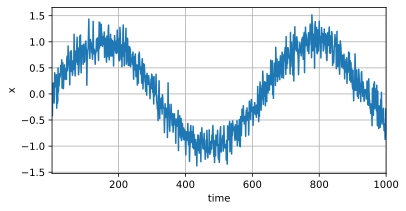

In [76]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [77]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [78]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [79]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.066944
epoch 2, loss: 0.050217
epoch 3, loss: 0.049473
epoch 4, loss: 0.047897
epoch 5, loss: 0.046107


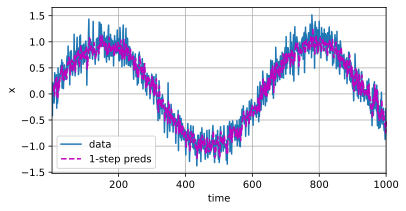

In [80]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

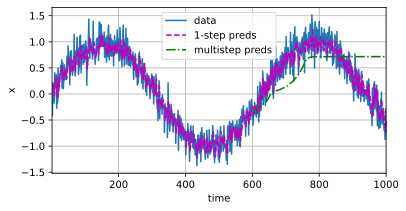

In [81]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

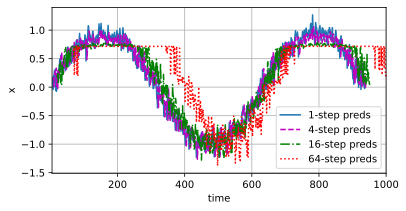

In [82]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))